In [3]:
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
%%time
stations_dict = pickle.load(open('stations_dict.p', "rb"))
stations_latlng = pickle.load(open('stations_latlng.p', "rb"))
#df = pd.read_feather('2017_all')
df = pd.read_feather('df_')
#df = pd.read_feather('df_train')

CPU times: user 4.17 s, sys: 9.55 s, total: 13.7 s
Wall time: 34.3 s


In [7]:
df.shape

(16202165, 30)

In [8]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'end station id', 'bikeid', 'usertype', 'birth year', 'gender',
       'starthour', 'date', 'weekday', 'weekend', 'month', 'time', 'Temp_high',
       'Temp_avg', 'Temp_low', 'Precip', 'Rain', 'Snow', 'Fog', 'rain_vol',
       'temp_level', 'lat1', 'lon1', 'lat2', 'lon2', 'start_cluster',
       'end_cluster'],
      dtype='object')

In [18]:
# 3248, 3480 special stations
sp_stations = [3248, 3480, 3247, 3215, 3478]
idx = df[(df['start station id'].isin(sp_stations)) 
          | (df['end station id'].isin(sp_stations))].index
df.drop(idx,0,inplace=True)

In [19]:
df.shape

(16196043, 31)

In [7]:
df.head(3)

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,starthour
0,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,498,21136,Subscriber,1987,2,0.0
1,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,3152,18147,Customer,-1,0,0.0
2,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143,3152,21211,Customer,-1,0,0.0


In [8]:
df.tail(3)

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,starthour
16659581,565,2017-12-31 23:56:07,2018-01-01 00:05:33,254,411,16125,Subscriber,1991,1,23.5
16659582,1659,2017-12-31 23:57:16,2018-01-01 00:24:56,495,3163,33328,Subscriber,1988,2,23.5
16659583,1279,2017-12-31 23:58:56,2018-01-01 00:20:16,3135,3143,31023,Subscriber,1968,2,23.5


In [9]:
# 2% of the trips ends up in the same station, ignore these for our purpose
print(df[df['start station id'] == df['end station id']].shape)
df = df[df['start station id'] != df['end station id']]

(329538, 10)


In [10]:
df.tripduration.quantile([0, .1, .25, .5, .75, .99, .999, .9999])

0.0000        61.000000
0.1000       237.000000
0.2500       368.000000
0.5000       611.000000
0.7500      1055.000000
0.9900      3166.000000
0.9990     16039.422000
0.9999    301717.545799
Name: tripduration, dtype: float64

In [11]:
# only look those trips are less or equal to one hour
df = df[df.tripduration <= 3600]
print(df.shape)

(16202165, 10)


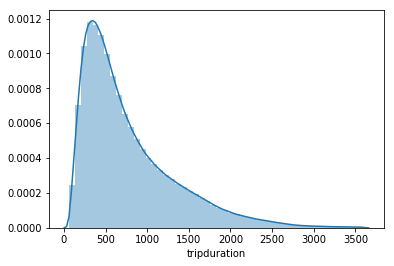

In [12]:
d = df.tripduration
sns.distplot(d, bins = 50);

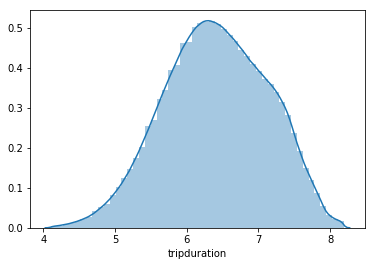

In [13]:
sns.distplot(np.log(d), bins = 50);
del d

In [14]:
Counter(df.usertype)

Counter({'Customer': 1592527, 'Subscriber': 14609638})

In [15]:
%%time
df['date'] = df['starttime'].apply(lambda x: x.date())

CPU times: user 45.3 s, sys: 1.56 s, total: 46.9 s
Wall time: 46.8 s


In [16]:
%%time
S = set(df['date'])
d = dict()
for s in S:
    d[s] = s.weekday() + 1

CPU times: user 894 ms, sys: 5.56 ms, total: 899 ms
Wall time: 899 ms


In [17]:
df['weekday'] = df['date'].map(d)

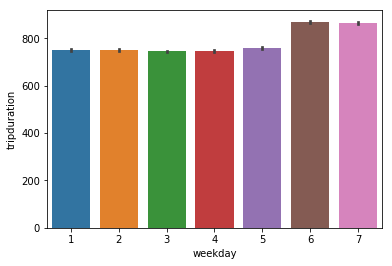

In [18]:
sns.barplot(x="weekday", y="tripduration", data=df.sample(500000))

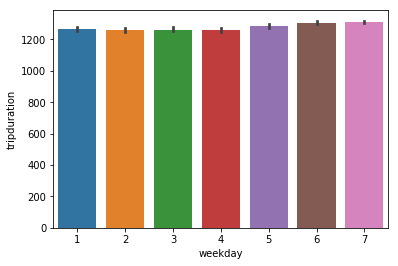

In [19]:
sns.barplot(x="weekday", y="tripduration", data=df[df.usertype == 'Customer'].sample(100000))

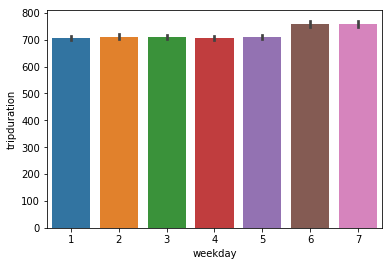

In [20]:
sns.barplot(x="weekday", y="tripduration", data=df[df.usertype == 'Subscriber'].sample(100000))

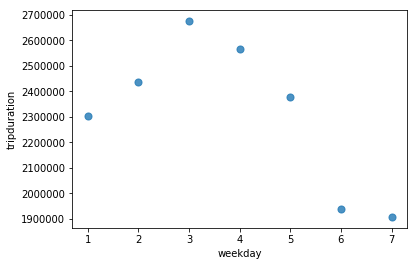

In [21]:
# number of trips vs. dow
tmp = df.groupby(['weekday']).tripduration.size().reset_index()
sns.regplot(x="weekday", y="tripduration", data=tmp,
            scatter_kws={"s": 50},
            order=2, ci=None, truncate=True, fit_reg=False)

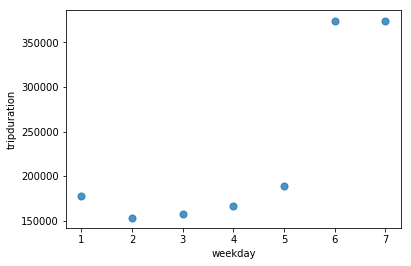

In [22]:
# consumer
# number of trips vs. dow
tmp = df[df.usertype == 'Customer'].groupby(['weekday']).tripduration.size().reset_index()
sns.regplot(x="weekday", y="tripduration", data=tmp,
            scatter_kws={"s": 50},
            order=2, ci=None, truncate=True, fit_reg=False)

In [23]:
%%time
df['weekend'] = df['weekday'].map(lambda x: 0 if x < 6 else 1)

CPU times: user 5 s, sys: 413 ms, total: 5.41 s
Wall time: 5.44 s


In [24]:
S = set(df.date)
d = dict()
for s in S:
    d[s] = s.month
df['month'] = df['date'].map(d)

,starthour,tripduration
0,0.0,81065
1,0.5,58510
2,1.0,44525
3,1.5,31821
4,2.0,24638
5,2.5,18350
6,3.0,14881
7,3.5,11298
8,4.0,10887
9,4.5,16020


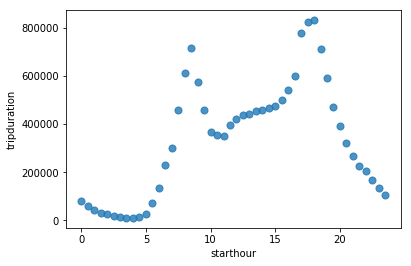

In [25]:
# number of trips vs. hours
tmp = df.groupby(['starthour']).tripduration.size().reset_index()
display(tmp)
sns.regplot(x="starthour", y="tripduration", data=tmp,
            scatter_kws={"s": 50}, ci=None, fit_reg=False);

In [26]:
def hour_min(time):
    t = time.split(':')
    return int(t[0])*100 + int(t[1])/60*100

In [27]:
%%time
df['time'] = df['starttime'].astype(str).apply(lambda x: x[11:])
df['time'] = df['time'].map(lambda x: hour_min(x))

CPU times: user 40.8 s, sys: 1.92 s, total: 42.7 s
Wall time: 42.7 s


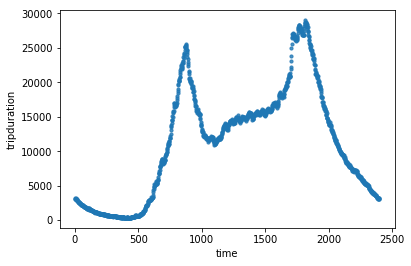

In [28]:
# number of trips vs. HH%MM
tmp = df.groupby(['time']).tripduration.size().reset_index()
sns.regplot(x="time", y="tripduration", data=tmp,
            scatter_kws={"s": 10}, ci=None, fit_reg=False);

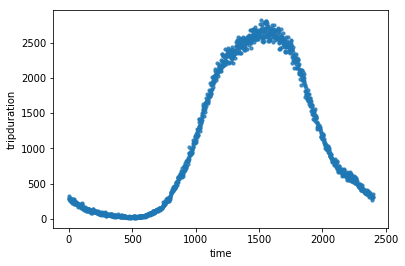

In [29]:
# Customer
# number of trips vs. HH%MM
tmp = df[df.usertype == 'Customer'].groupby(['time']).tripduration.size().reset_index()
sns.regplot(x="time", y="tripduration", data=tmp,
            scatter_kws={"s": 10}, ci=None, fit_reg=False);

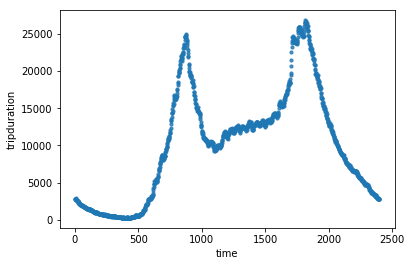

In [30]:
# Customer
# number of trips vs. HH%MM
tmp = df[df.usertype == 'Subscriber'].groupby(['time']).tripduration.size().reset_index()
sns.regplot(x="time", y="tripduration", data=tmp,
            scatter_kws={"s": 10}, ci=None, fit_reg=False);

CPU times: user 8.15 s, sys: 977 ms, total: 9.13 s
Wall time: 9.14 s


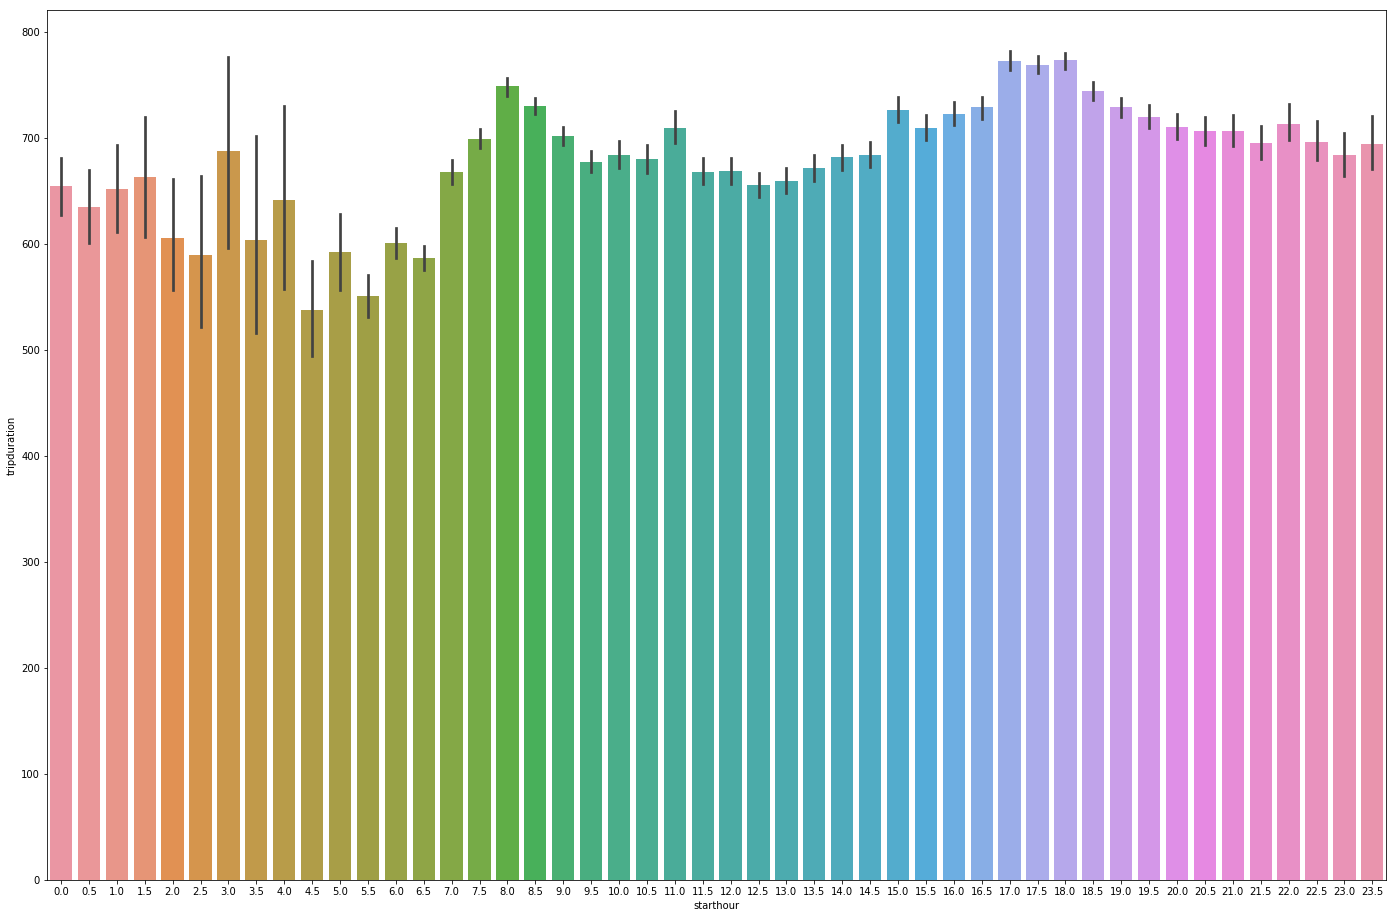

In [31]:
%%time
plt.figure(figsize=(24,16))
sns.barplot(x="starthour", y="tripduration", 
            data=df[(df.usertype == 'Subscriber') & (df.weekend == 0)].sample(300000))

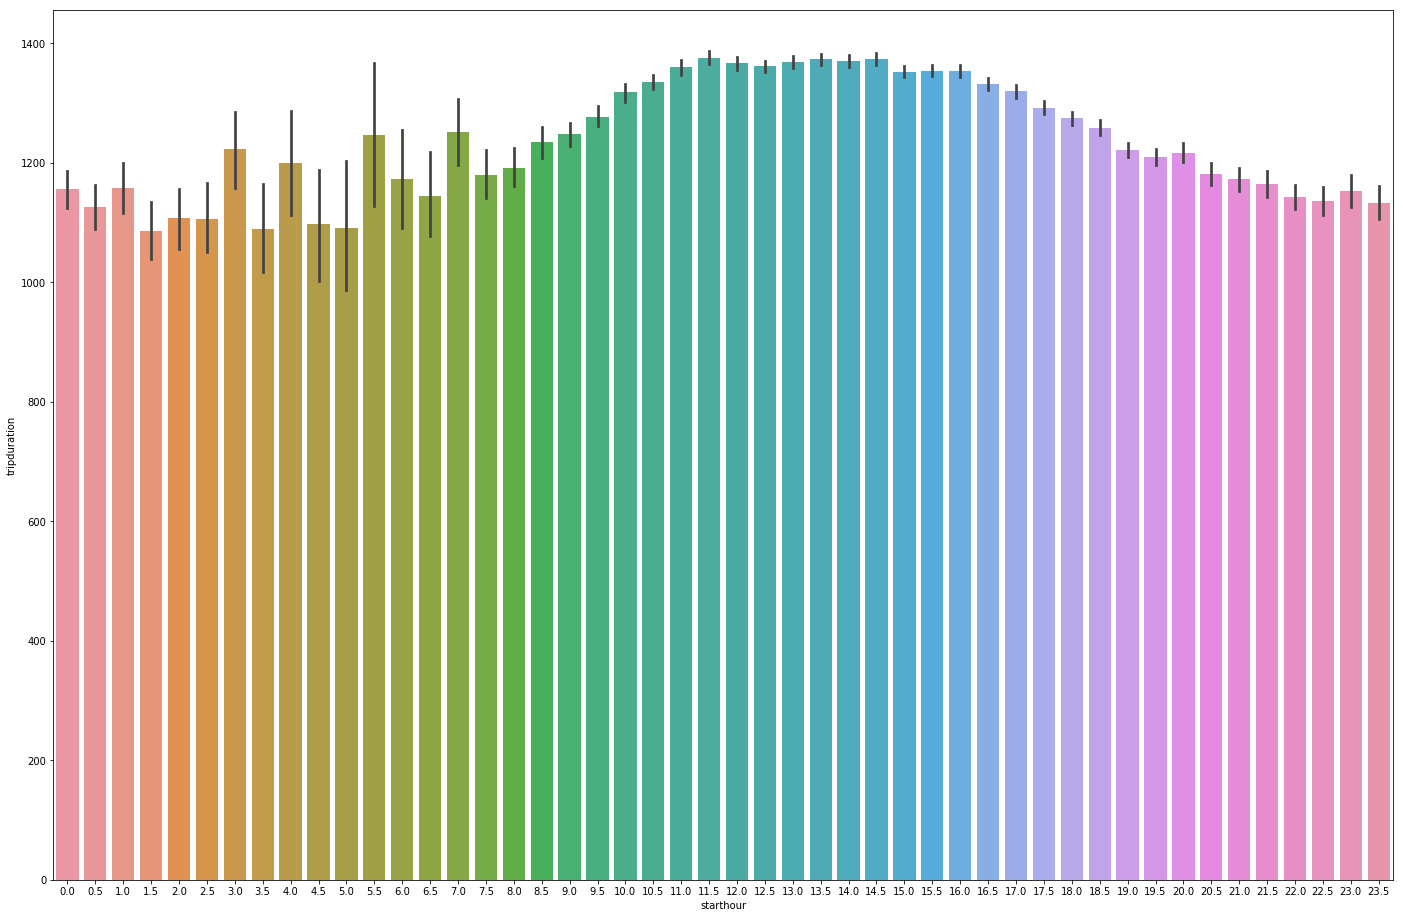

In [32]:
plt.figure(figsize=(24,16))
sns.barplot(x="starthour", y="tripduration", 
            data=df[(df.usertype == 'Customer') & (df.weekend == 1)].sample(300000))

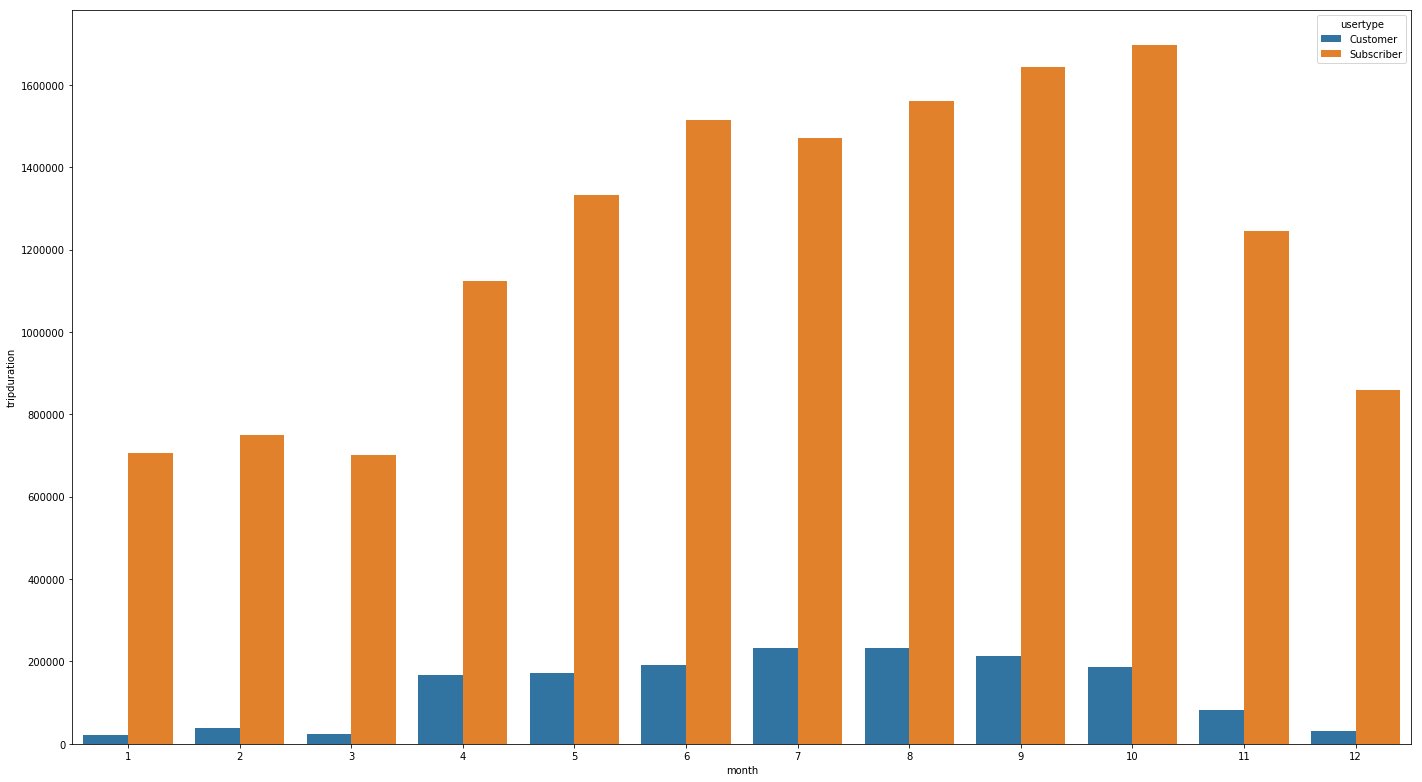

In [33]:
tmp = df.groupby(['month', 'usertype']).tripduration.size().reset_index()
plt.figure(figsize=(24,13.5))
sns.barplot(x="month", y="tripduration", hue="usertype",
            data=tmp);

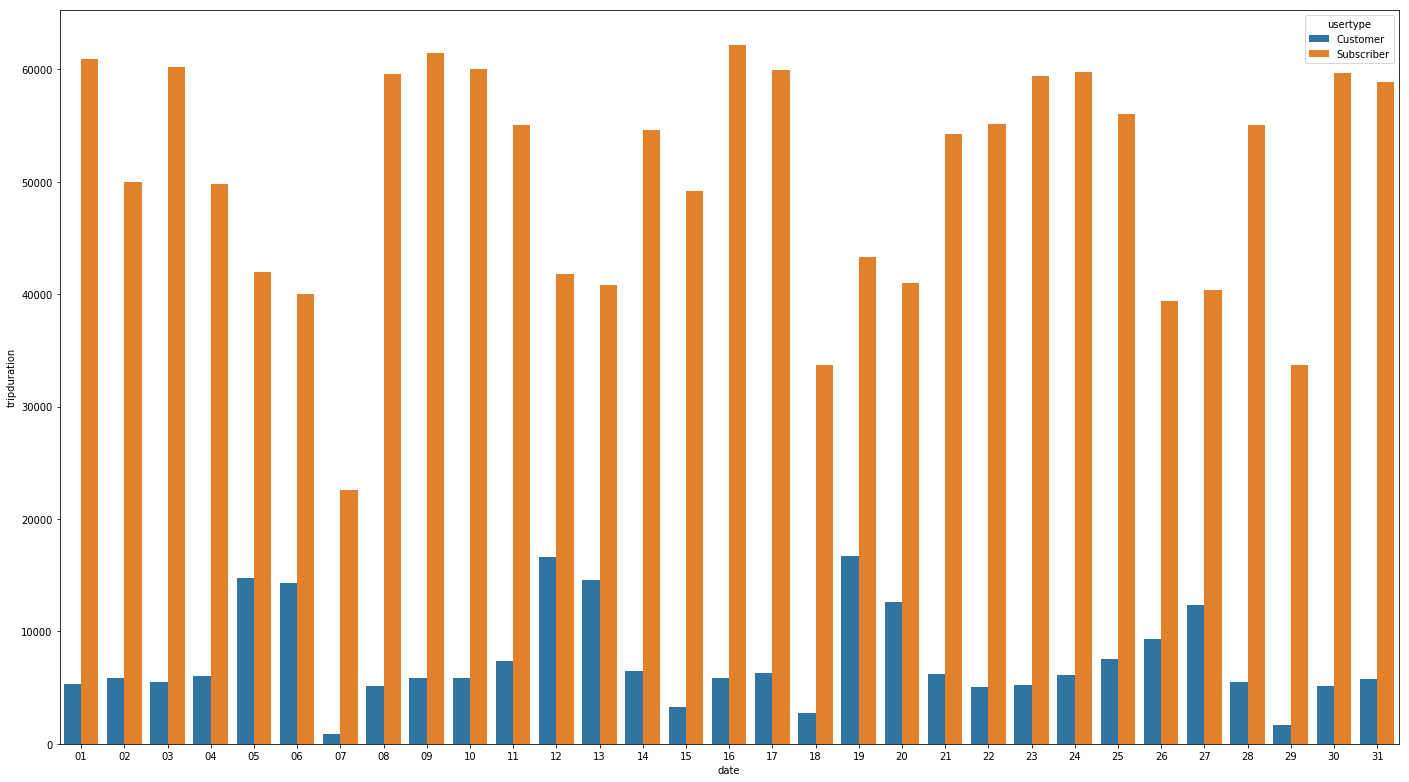

In [34]:
# number of trips vs. day

tmp = df[df['month']==8].groupby(['date', 'usertype']).tripduration.size().reset_index()
tmp['date'] = tmp['date'].apply(lambda x: str(x)[-2:])
plt.figure(figsize=(24,13.5))
sns.barplot(x="date", y="tripduration", hue="usertype",
            data=tmp);

In [13]:
from datetime import datetime
def display_all(df):
    """
    display more than 20 rows/cols
    """
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [36]:
nyc_temp = pd.read_csv('nyc_temp_2017.csv')
nyc_temp['2017'] = nyc_temp['2017'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
nyc_temp.columns = ['date', 'Temp_high', 'Temp_avg', 'Temp_low', 'Precip', 'Rain', 'Snow', 'Fog']
nyc_temp.sample(5)

,date,Temp_high,Temp_avg,Temp_low,Precip,Rain,Snow,Fog
125,2017-05-06,67,60,52,0.180,1,0,0
162,2017-06-12,93,85,76,0.000,0,0,0
121,2017-05-02,75,69,62,0.001,0,0,0
330,2017-11-27,51,45,39,0.000,0,0,0
107,2017-04-18,65,56,47,0.000,0,0,0


In [37]:
%%time
df = pd.merge(df, nyc_temp, 'left', on='date')

CPU times: user 7.32 s, sys: 4.91 s, total: 12.2 s
Wall time: 13.4 s


In [38]:
df.Precip.quantile(np.clip(np.arange(.7, 1., .05), 0, 1))

0.70    0.001
0.75    0.010
0.80    0.030
0.85    0.080
0.90    0.200
0.95    0.450
1.00    3.030
Name: Precip, dtype: float64

In [39]:
df['rain_vol'] = 0
# v light, medium, heavy
df.loc[df['Precip'] >= 0.001, 'rain_vol'] = 1
df.loc[df['Precip'] >= 0.03, 'rain_vol'] = 2
df.loc[df['Precip'] >= 0.2, 'rain_vol'] = 3

df['temp_level'] = 0
df.loc[df['Temp_high'] >= 56, 'temp_level'] = 1
df.loc[df['Temp_high'] >= 67, 'temp_level'] = 2
df.loc[df['Temp_high'] >= 76, 'temp_level'] = 3
df.loc[df['Temp_high'] >= 83, 'temp_level'] = 4

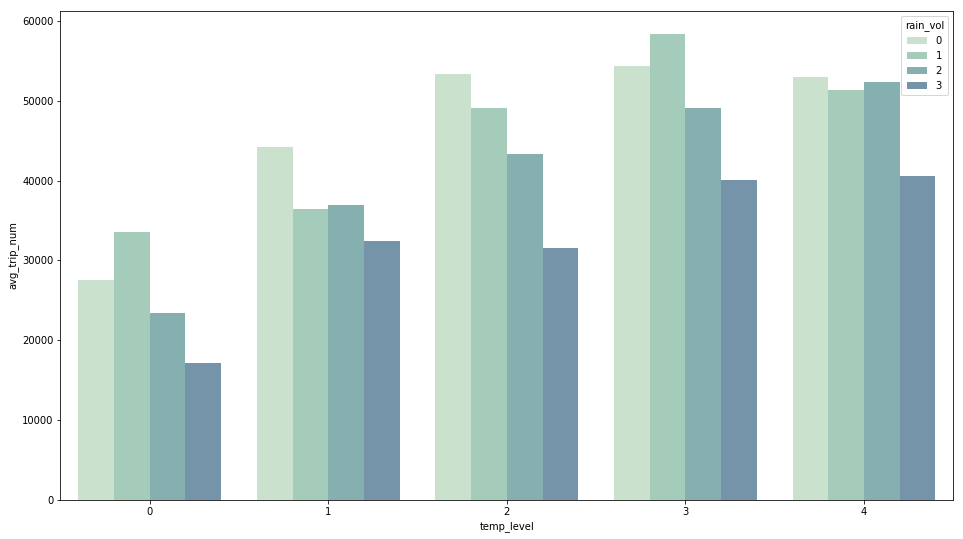

In [42]:
tmp = df[df.usertype == 'Subscriber']\
    .groupby(['temp_level','rain_vol'])\
        .agg({'tripduration': 'size', 
              'date': lambda x: x.nunique()}).reset_index()
        
tmp['avg_trip_num'] = tmp['tripduration']/tmp['date']

g = sns.barplot(x="temp_level", 
                y="avg_trip_num", 
                data=tmp, 
                hue="rain_vol",
                palette=sns.cubehelix_palette(8, start=.9, rot=-.75))
#             scatter_kws={"s": 10}, ci=None, fit_reg=False);

g.figure.set_size_inches(16, 9)

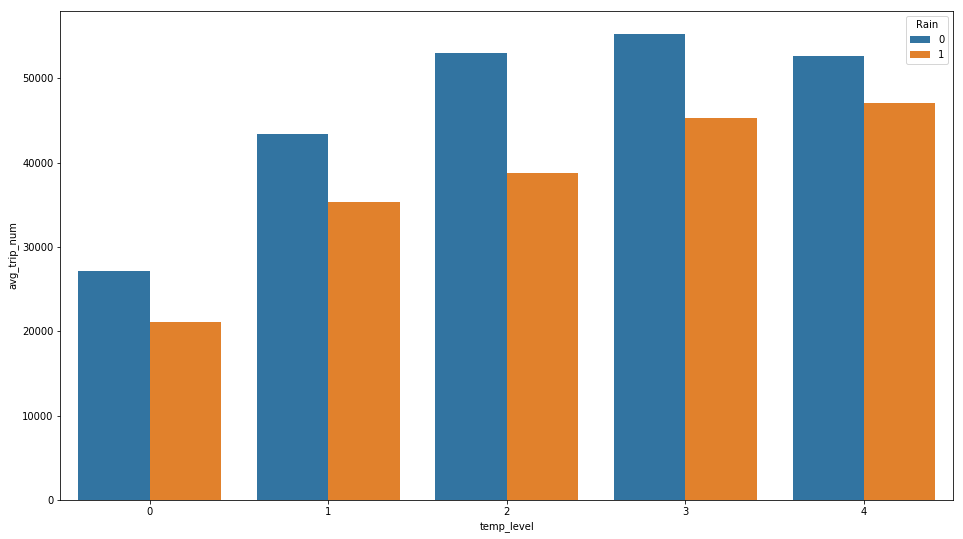

In [43]:
tmp = df[df.usertype == 'Subscriber']\
    .groupby(['temp_level','Rain'])\
        .agg({'tripduration': 'size', 
              'date': lambda x: x.nunique()}).reset_index()
        
tmp['avg_trip_num'] = tmp['tripduration']/tmp['date']

g = sns.barplot(x="temp_level", y="avg_trip_num", data=tmp, hue="Rain",)
#             scatter_kws={"s": 10}, ci=None, fit_reg=False);

g.figure.set_size_inches(16, 9)

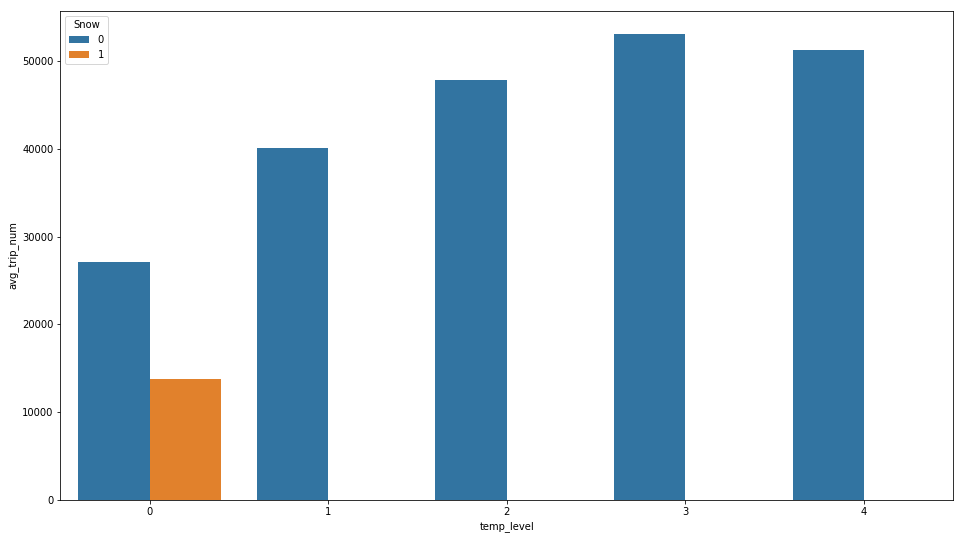

In [44]:
tmp = df[df.usertype == 'Subscriber']\
    .groupby(['temp_level','Snow'])\
        .agg({'tripduration': 'size', 
              'date': lambda x: x.nunique()}).reset_index()
        
tmp['avg_trip_num'] = tmp['tripduration']/tmp['date']

g = sns.barplot(x="temp_level", y="avg_trip_num", data=tmp, hue="Snow",)
#             scatter_kws={"s": 10}, ci=None, fit_reg=False);

g.figure.set_size_inches(16, 9)

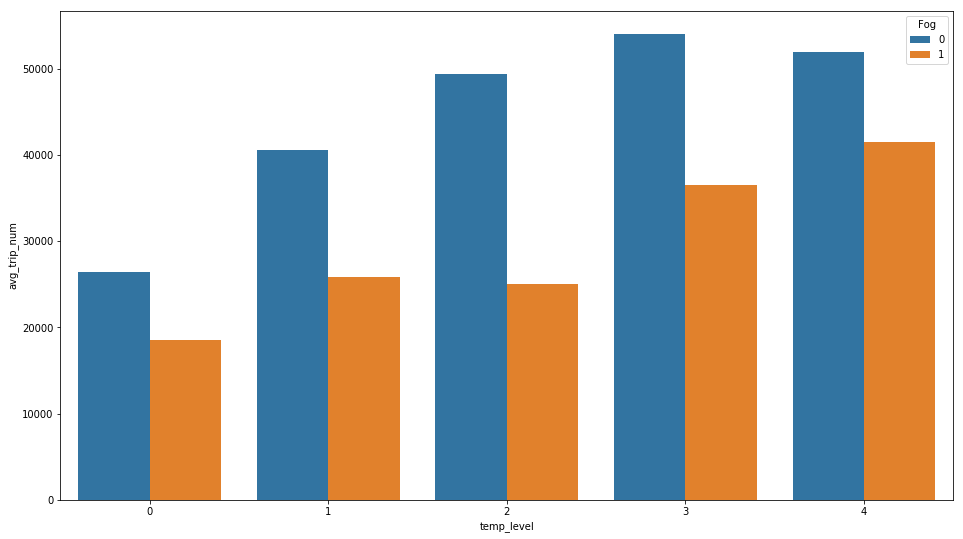

In [45]:
tmp = df[df.usertype == 'Subscriber']\
    .groupby(['temp_level','Fog'])\
        .agg({'tripduration': 'size', 
              'date': lambda x: x.nunique()}).reset_index()
        
tmp['avg_trip_num'] = tmp['tripduration']/tmp['date']

g = sns.barplot(x="temp_level", y="avg_trip_num", data=tmp, hue="Fog",)
#             scatter_kws={"s": 10}, ci=None, fit_reg=False);

g.figure.set_size_inches(16, 9)

CPU times: user 21.6 s, sys: 1.65 s, total: 23.2 s
Wall time: 23.3 s


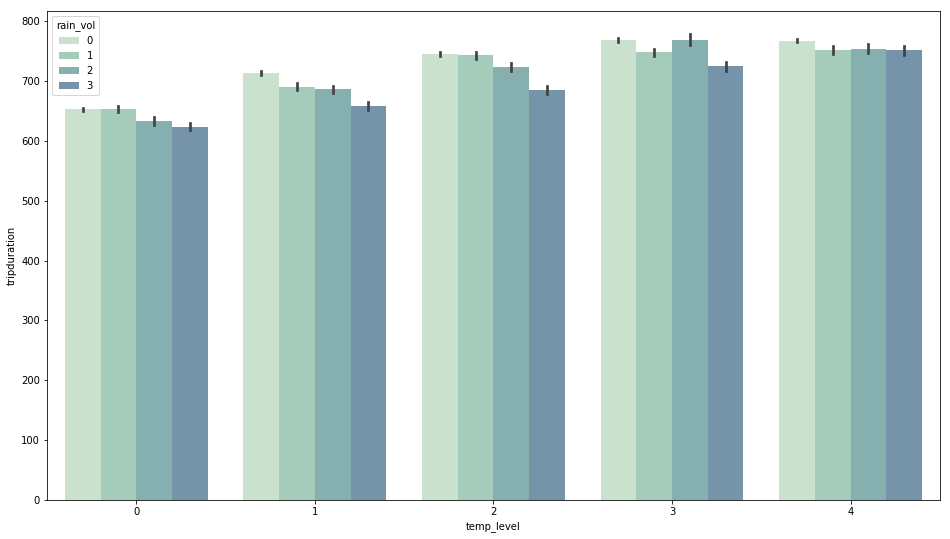

In [46]:
%%time
g = sns.barplot(x="temp_level", y="tripduration", 
                hue="rain_vol", 
                data=df[df.usertype == 'Subscriber'].sample(1000000),
                palette=sns.cubehelix_palette(8, start=.9, rot=-.75));
g.figure.set_size_inches(16, 9)

In [47]:
%%time
df['lat1'] = df['start station id'].map(lambda x: stations_latlng[x][0])
df['lon1'] = df['start station id'].map(lambda x: stations_latlng[x][1])
df['lat2'] = df['end station id'].map(lambda x: stations_latlng[x][0])
df['lon2'] = df['end station id'].map(lambda x: stations_latlng[x][1])

CPU times: user 28.6 s, sys: 2.16 s, total: 30.8 s
Wall time: 31 s


In [6]:
from math import sin, cos, sqrt, atan2, radians
def manhattan_distance(latlon1, latlon2):
    R = 6371

    lat1 = radians(latlon1[0])
    lon1 = radians(latlon1[1])
    lat2 = radians(latlon2[0])
    lon2 = radians(latlon2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a1 = sin(dlat / 2)**2 
    c1 = 2 * atan2(sqrt(a1), sqrt(1 - a1))
    d1 = R * c1
    
    a2 = sin(dlon / 2)**2
    c2 = 2 * atan2(sqrt(a2), sqrt(1 - a2))
    d2 = R * c2
    
    return d1+d2

In [33]:
d1 = stations_latlng[523]
d1

d2 = stations_latlng[428]
d2

a = abs(d1[0]-d2[0])
b = abs(d1[1]-d2[1])

(a+b)*111.195

3.7290455392526001

In [34]:
manhattan_distance(d1, d2)

3.729043079198083

In [53]:
d1

(40.754665909936371, -73.991381520106231)

In [54]:
d2

(40.724677209979468, -73.987834129957889)

In [56]:
%%time
tmp = df.groupby(['start station id', 'end station id']).size().reset_index()
tmp.columns = ['start station id', 'end station id', 'size']
tmp = tmp.sort_values('size', ascending=False).reset_index()

CPU times: user 1.17 s, sys: 314 ms, total: 1.48 s
Wall time: 1.48 s


In [57]:
%%time
tmp['lat1'] = tmp['start station id'].map(lambda x: stations_latlng[x][0])
tmp['lon1'] = tmp['start station id'].map(lambda x: stations_latlng[x][1])
tmp['lat2'] = tmp['end station id'].map(lambda x: stations_latlng[x][0])
tmp['lon2'] = tmp['end station id'].map(lambda x: stations_latlng[x][1])

lat2 = tmp['lat2'].values
lon2 = tmp['lon2'].values

CPU times: user 503 ms, sys: 57.6 ms, total: 561 ms
Wall time: 560 ms


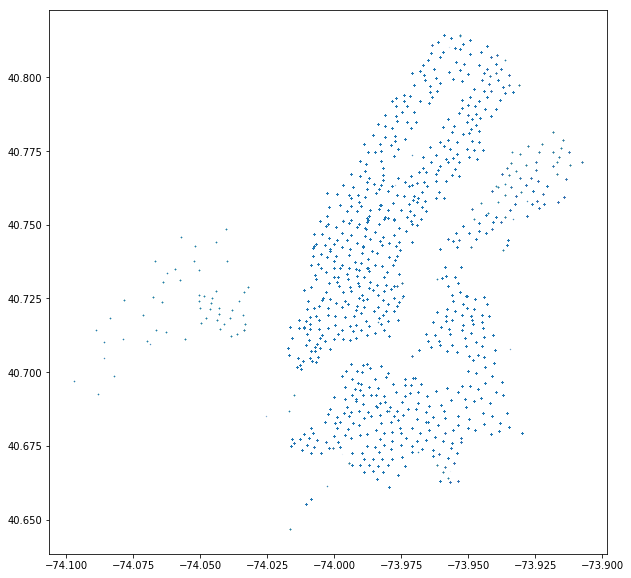

In [58]:
plt.figure(figsize = (10,10))
plt.plot(lon2,lat2,'.', alpha = 0.8, markersize = 0.1)
plt.show()

In [59]:
def latlon2pos(lat, lon, size=240):
    return int(round((40.84-lat)*size/240*1000-1)), int(round((lon+74.12)*size/240*1000-1))

(855, 5)
CPU times: user 662 ms, sys: 275 ms, total: 938 ms
Wall time: 936 ms


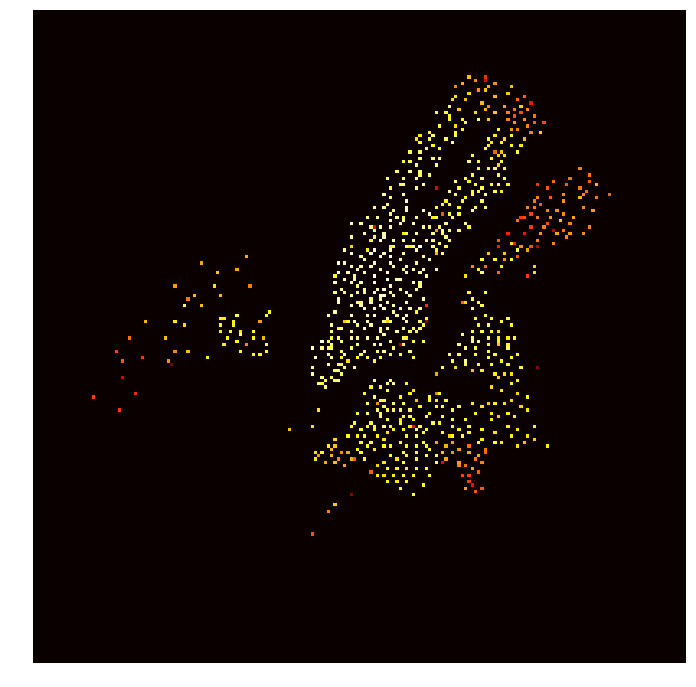

In [60]:
%%time
tmp = df.groupby(['start station id']).size().reset_index()
tmp.columns = ['start station id', 'size']
tmp = tmp.sort_values('size', ascending=False).reset_index()

tmp['lat1'] = tmp['start station id'].map(lambda x: stations_latlng[x][0])
tmp['lon1'] = tmp['start station id'].map(lambda x: stations_latlng[x][1])
print(tmp.shape)
# show the log density of pickup and dropoff locations
s = 200
imageSize = (s,s)

locationDensityImage = np.zeros(imageSize)
for i in range(len(tmp)):
    t = tmp.loc[i]
    locationDensityImage[latlon2pos(t['lat1'], t['lon1'], s)] += t['size']#np.log1p(t['size'])

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log1p(locationDensityImage), cmap='hot')
ax.set_axis_off()

(857, 5)
CPU times: user 566 ms, sys: 160 ms, total: 725 ms
Wall time: 724 ms


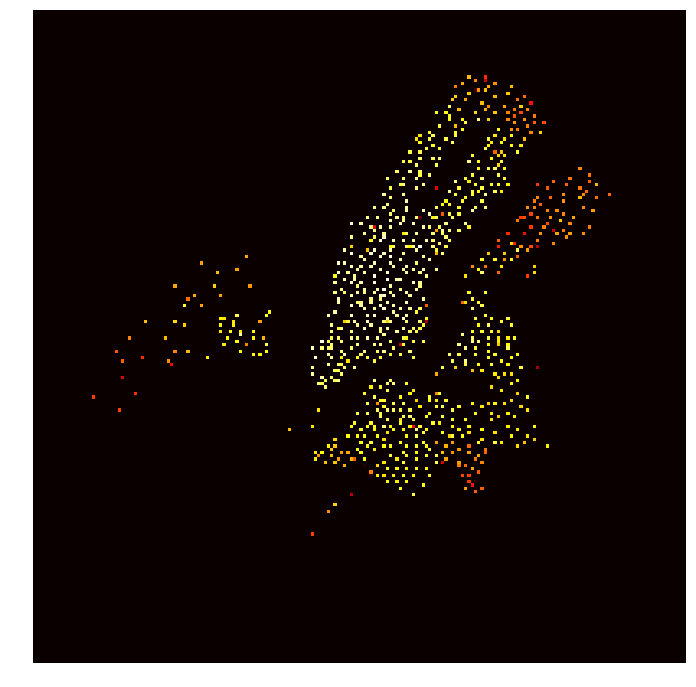

In [61]:
%%time
tmp = df.groupby(['end station id']).size().reset_index()
tmp.columns = ['end station id', 'size']
tmp = tmp.sort_values('size', ascending=False).reset_index()

tmp['lat1'] = tmp['end station id'].map(lambda x: stations_latlng[x][0])
tmp['lon1'] = tmp['end station id'].map(lambda x: stations_latlng[x][1])
print(tmp.shape)
# show the log density of pickup and dropoff locations
s = 200
imageSize = (s,s)

locationDensityImage1 = np.zeros(imageSize)
for i in range(len(tmp)):
    t = tmp.loc[i]
    locationDensityImage1[latlon2pos(t['lat1'], t['lon1'], s)] += t['size']#np.log1p(t['size'])

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log1p(locationDensityImage1), cmap='hot')
ax.set_axis_off()

In [63]:
from sklearn.cluster import KMeans

In [802]:
# %%time
# tmp = df[['start station id']].sample(200000)
# loc_df = pd.DataFrame()
# loc_df['longitude'] = tmp['start station id'].map(lambda x: stations_latlng[x][1])
# loc_df['latitude'] = tmp['start station id'].map(lambda x: stations_latlng[x][0])

# Ks = range(5, 50)
# km = [KMeans(n_clusters=i) for i in Ks]
# score = [km[i].fit(loc_df).score(loc_df) for i in range(len(km))]
# score = [abs(i) for i in score]

CPU times: user 23min 55s, sys: 2min 10s, total: 26min 5s
Wall time: 6min 50s


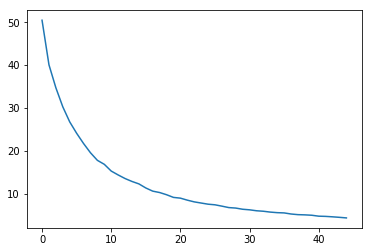

In [808]:
plt.plot((score))

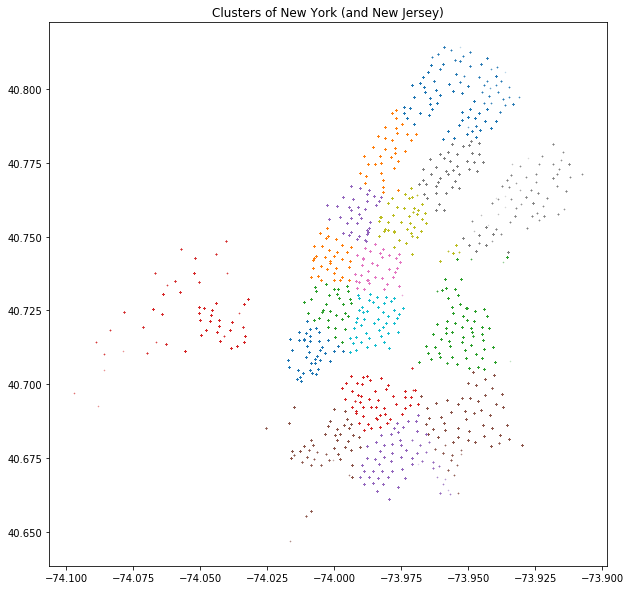

CPU times: user 14.1 s, sys: 1.53 s, total: 15.6 s
Wall time: 6.99 s


In [127]:
%%time
tmp = df[['start station id']].sample(200000)
loc_df = pd.DataFrame()
loc_df['longitude'] = tmp['start station id'].map(lambda x: stations_latlng[x][1])
loc_df['latitude'] = tmp['start station id'].map(lambda x: stations_latlng[x][0])

kmeans = KMeans(n_clusters=16, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_


plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 1)

plt.title('Clusters of New York (and New Jersey)')
plt.show()

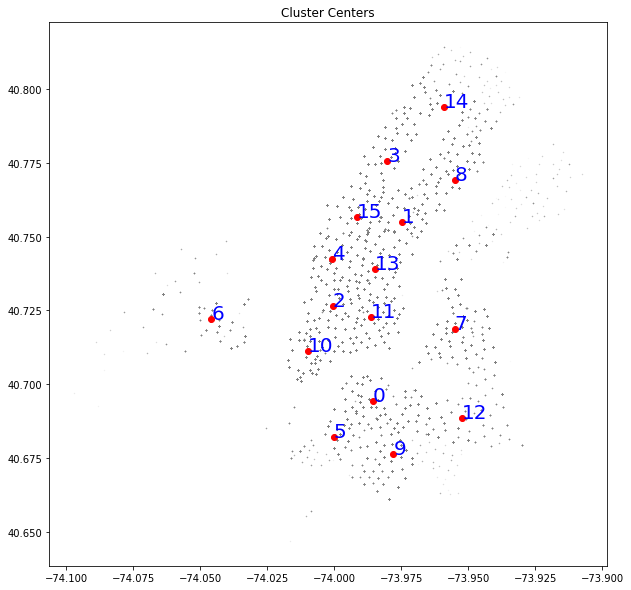

In [128]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [96]:
%%time
df['start_cluster'] = kmeans.predict(df[['lon1','lat1']])
df['end_cluster'] = kmeans.predict(df[['lon2','lat2']])

CPU times: user 8.34 s, sys: 562 ms, total: 8.9 s
Wall time: 8.91 s


In [97]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [120]:
loc_df = loc_df.sample(5000)

NameError: name 'loc_df_' is not defined

In [115]:
import os
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.cluster import KMeans
from IPython.display import HTML
from subprocess import check_output
import io
import base64

In [124]:
%%time
fig, ax = plt.subplots(1, 1, figsize = (10,10))
df_ = df.sample(5000000)

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(hour))    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df_[(df_.start_cluster == label) & (df_.end_cluster == dest_label) & (df_.starthour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df_))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')

ani = animation.FuncAnimation(fig,animate,sorted(df.starthour.unique()), interval = 1000);
plt.close();
ani.save('Absolute.gif', writer='imagemagick', fps=2);
filename = 'Absolute.gif'
video = io.open(filename, 'r+b').read();
encoded = base64.b64encode(video);
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')));


MovieWriter imagemagick unavailable.


CPU times: user 5min 53s, sys: 1min 51s, total: 7min 45s
Wall time: 7min 53s


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [123]:
%%time
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(hour))    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df_[(df_.start_cluster == label) & (df_.end_cluster == dest_label) & (df_.starthour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df_[df_.starthour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df_.starthour.unique()), interval = 1000)
plt.close()
ani.save('Relative.gif', writer='imagemagick', fps=2)
filename = 'Relative.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

MovieWriter imagemagick unavailable.


CPU times: user 3min 43s, sys: 5.16 s, total: 3min 48s
Wall time: 3min 50s


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [130]:
df.tripduration.quantile([0, .25, .5, .75, 1.])

0.00      61.0
0.25     366.0
0.50     607.0
0.75    1040.0
1.00    3600.0
Name: tripduration, dtype: float64

In [133]:
df.to_feather('df_')

In [9]:
def col_encode(col):
    """Encodes a pandas column with continous ids. 
    """
    uniq = np.unique(col)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx#, np.array([name2idx[x] for x in col]), len(uniq)

In [10]:
col_encode(df['usertype'])

{'Customer': 0, 'Subscriber': 1}

In [11]:
%%time
df['user_enc'] = df['usertype'].map(col_encode(df['usertype']))

CPU times: user 20.9 s, sys: 271 ms, total: 21.2 s
Wall time: 21.2 s


In [14]:
display_all(df.head(5))

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,starthour,date,weekday,weekend,month,time,Temp_high,Temp_avg,Temp_low,Precip,Rain,Snow,Fog,rain_vol,temp_level,lat1,lon1,lat2,lon2,start_cluster,end_cluster,user_enc
0,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,498,21136,Subscriber,1987,2,0.0,2017-01-01,7,1,1,0.000000,46,44,41,0.0,0,0,0,0,0,40.729307,-73.990839,40.748549,-73.988084,5,1,1
1,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,3152,18147,Customer,-1,0,0.0,2017-01-01,7,1,1,0.000000,46,44,41,0.0,0,0,0,0,0,40.776372,-73.964235,40.768737,-73.961199,14,14,0
2,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143,3152,21211,Customer,-1,0,0.0,2017-01-01,7,1,1,1.666667,46,44,41,0.0,0,0,0,0,0,40.776372,-73.964235,40.768737,-73.961199,14,14,0
3,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143,3152,26819,Customer,-1,0,0.0,2017-01-01,7,1,1,1.666667,46,44,41,0.0,0,0,0,0,0,40.776372,-73.964235,40.768737,-73.961199,14,14,0
4,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499,479,27294,Subscriber,1973,1,0.0,2017-01-01,7,1,1,8.333333,46,44,41,0.0,0,0,0,0,0,40.769155,-73.981918,40.760193,-73.991255,7,7,1


In [15]:
%%time
# naive distance
df['est_dist'] = abs(df['lat1'] - df['lat2']) + abs(df['lon1'] - df['lon2'])
df['est_dist'] = df['est_dist'] * 111195

CPU times: user 698 ms, sys: 210 ms, total: 909 ms
Wall time: 444 ms


CPU times: user 3.4 s, sys: 578 ms, total: 3.98 s
Wall time: 4.1 s


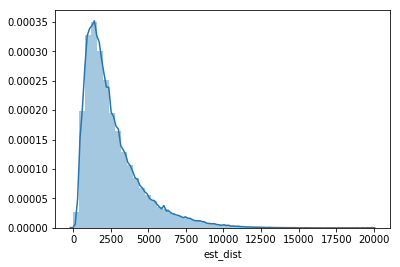

In [24]:
%%time
d = df.est_dist
sns.distplot(d, bins = 50);
del d

In [47]:
np.array(df.est_dist).reshape(1, -1)

array([[ 2445.83958415,  1186.58065488,  1186.58065488, ...,
         3820.71579507,  2879.34782726,  1307.12492693]])

In [16]:
%%time
for i in ['starttime', 'stoptime', 'bikeid', 'usertype']:
    try:
        df.drop([i], 1, inplace=True)
    except:
        pass

CPU times: user 9.41 s, sys: 12.3 s, total: 21.7 s
Wall time: 23.1 s


In [25]:
df.est_dist.quantile([.5, .95, .97, .98, .99, 1.])

0.50     2067.339662
0.95     6643.651056
0.97     7657.077835
0.98     8380.180045
0.99     9529.209129
1.00    19882.601152
Name: est_dist, dtype: float64

In [31]:
display_all(df.sample(5))

,tripduration,start station id,end station id,birth year,gender,starthour,date,weekday,weekend,month,time,Temp_high,Temp_avg,Temp_low,Precip,Rain,Snow,Fog,rain_vol,temp_level,lat1,lon1,lat2,lon2,start_cluster,end_cluster,est_dist
16090312,255,3161,3166,1969,1,15.5,2017-12-22,5,0,12,1565.000000,50,43,35,0.0,0,0,0,0,0,40.780184,-73.977285,40.780578,-73.985624,2,2,971.066546
10774526,421,382,284,1985,1,20.0,2017-09-10,7,1,9,2035.000000,72,65,57,0.0,0,0,0,0,2,40.734927,-73.992005,40.739017,-74.002638,9,1,1637.066391
11956604,1480,435,3166,1971,1,17.0,2017-09-28,4,0,9,1715.000000,79,69,59,0.0,0,0,0,0,3,40.741740,-73.994156,40.780578,-73.985624,1,2,5267.256743
4568867,2659,3295,441,-1,0,14.0,2017-05-21,7,1,5,1428.333333,69,61,52,0.0,0,0,0,0,2,40.791270,-73.964839,40.756014,-73.967416,8,13,4206.840440
11431798,480,517,497,1980,1,18.0,2017-09-20,3,0,9,1840.000000,79,75,71,0.0,0,0,0,0,3,40.751581,-73.977910,40.737050,-73.990093,13,9,2970.476590


In [17]:
df['speed'] = df.est_dist/df.tripduration

In [18]:
df.speed.quantile([0, .1, .2, .3, .4, .5, .6, .7 ,.8, .9, 1.])

0.0      0.000015
0.1      2.061790
0.2      2.646318
0.3      3.037958
0.4      3.369201
0.5      3.681847
0.6      4.000142
0.7      4.346626
0.8      4.759731
0.9      5.347888
1.0    105.474367
Name: speed, dtype: float64

In [19]:
df.speed.quantile([.9, .92, .94 ,.96, .98, .99, .995, 1.])

0.900      5.347888
0.920      5.516835
0.940      5.723068
0.960      5.995854
0.980      6.425189
0.990      6.820558
0.995      7.188916
1.000    105.474367
Name: speed, dtype: float64

In [20]:
idx = df[df.speed > 10].index
df.drop(idx, 0 ,inplace=True)

In [21]:
df = df.reset_index()

CPU times: user 4.17 s, sys: 1.2 s, total: 5.37 s
Wall time: 5.4 s


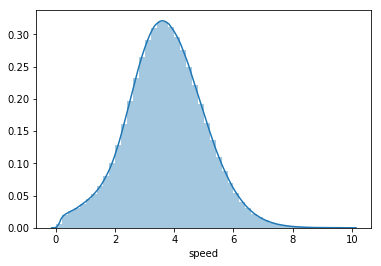

In [22]:
%%time
d = df.speed
sns.distplot(d, bins = 50);
del d

In [23]:
%%time
for i in ['index', 'lat1', 'lon1', 'lat2', 'lon2', 'time', 'speed']:
    try:
        df.drop([i], 1, inplace=True)
    except:
        pass

CPU times: user 9.26 s, sys: 10.8 s, total: 20.1 s
Wall time: 20.1 s


In [24]:
display_all(df.head())

,tripduration,start station id,end station id,birth year,gender,starthour,date,weekday,weekend,month,Temp_high,Temp_avg,Temp_low,Precip,Rain,Snow,Fog,rain_vol,temp_level,start_cluster,end_cluster,user_enc,est_dist
0,1282,3263,498,1987,2,0.0,2017-01-01,7,1,1,46,44,41,0.0,0,0,0,0,0,5,1,1,2445.839584
1,648,3143,3152,-1,0,0.0,2017-01-01,7,1,1,46,44,41,0.0,0,0,0,0,0,14,14,0,1186.580655
2,631,3143,3152,-1,0,0.0,2017-01-01,7,1,1,46,44,41,0.0,0,0,0,0,0,14,14,0,1186.580655
3,621,3143,3152,-1,0,0.0,2017-01-01,7,1,1,46,44,41,0.0,0,0,0,0,0,14,14,0,1186.580655
4,559,499,479,1973,1,0.0,2017-01-01,7,1,1,46,44,41,0.0,0,0,0,0,0,7,7,1,2034.781759


In [167]:
date_temp = df.groupby(['month']).Temp_high.mean().reset_index()
date_temp['month'] = date_temp['month']-1
date_temp.columns = ['month', 'temp']

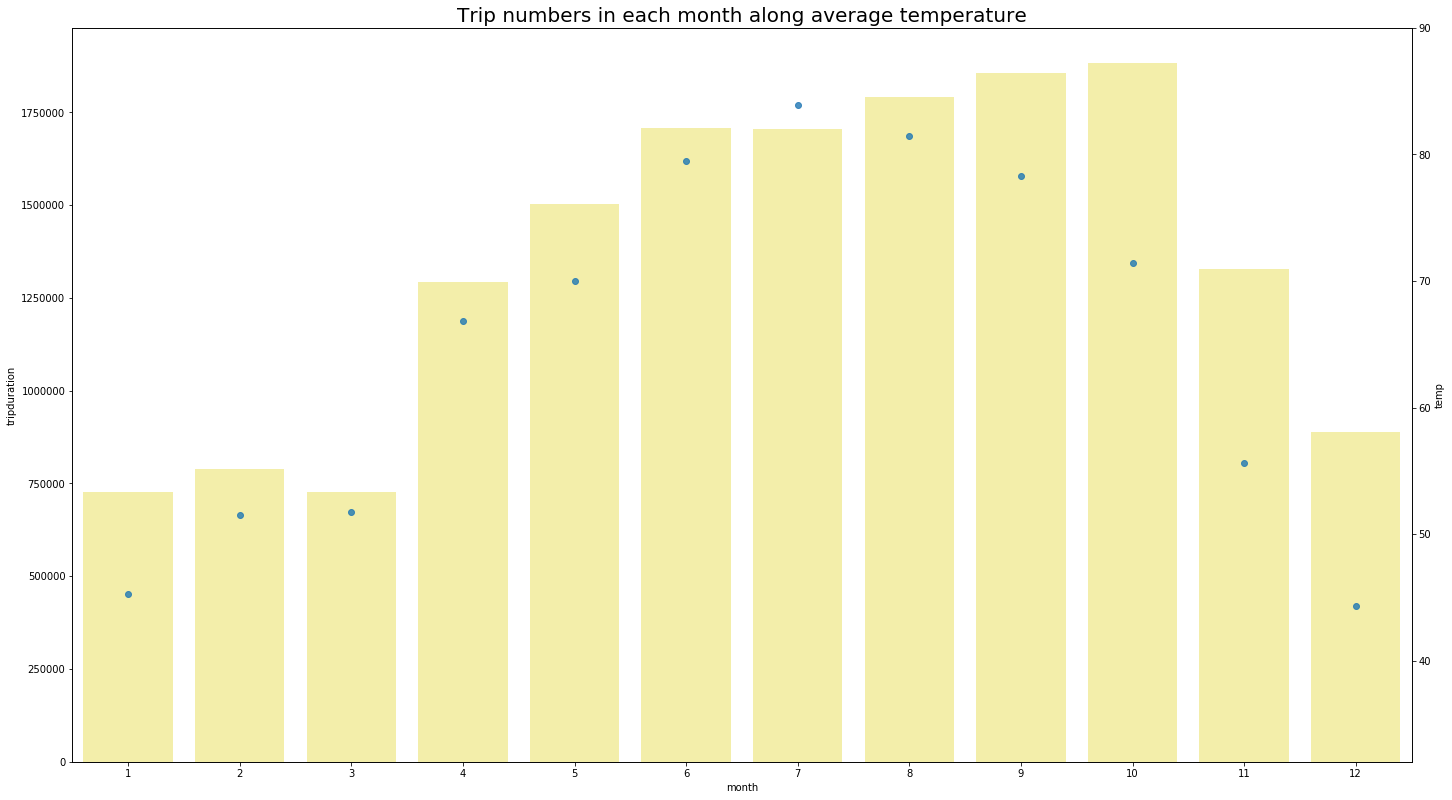

In [180]:
tmp = df.groupby(['month']).tripduration.size().reset_index()
#tmp = pd.merge(tmp, date_temp, 'left', 'month')

fig, ax = plt.subplots(figsize=(24,13.5))
ax2 = ax.twinx()

sns.barplot(x="month", y="tripduration", data=tmp, color="#fff89e", ax=ax);
sns.regplot(x="month", y="temp", data=date_temp, ax=ax2, fit_reg=False);

ax.set_ylim(0, None)
ax2.set_ylim(32, 90)
plt.title('Trip numbers in each month along average temperature', fontsize=20)
plt.show()

In [25]:
tmp = df[['date', 'Temp_high']].groupby(['date']).first().reset_index()
tmp['diff'] = 0
tmp.loc[1:, 'diff'] = np.diff(tmp.Temp_high)
tmp.head()

,date,Temp_high,diff
0,2017-01-01,46,0
1,2017-01-02,39,-7
2,2017-01-03,43,4
3,2017-01-04,52,9
4,2017-01-05,33,-19


In [26]:
temp_d = dict(zip(tmp['date'], tmp['diff']))

In [27]:
%%time
df['temp_diff'] = df['date'].map(temp_d)

CPU times: user 49.3 s, sys: 1.54 s, total: 50.8 s
Wall time: 50.9 s


In [28]:
df['est_dist'] = df['est_dist'].astype(int)

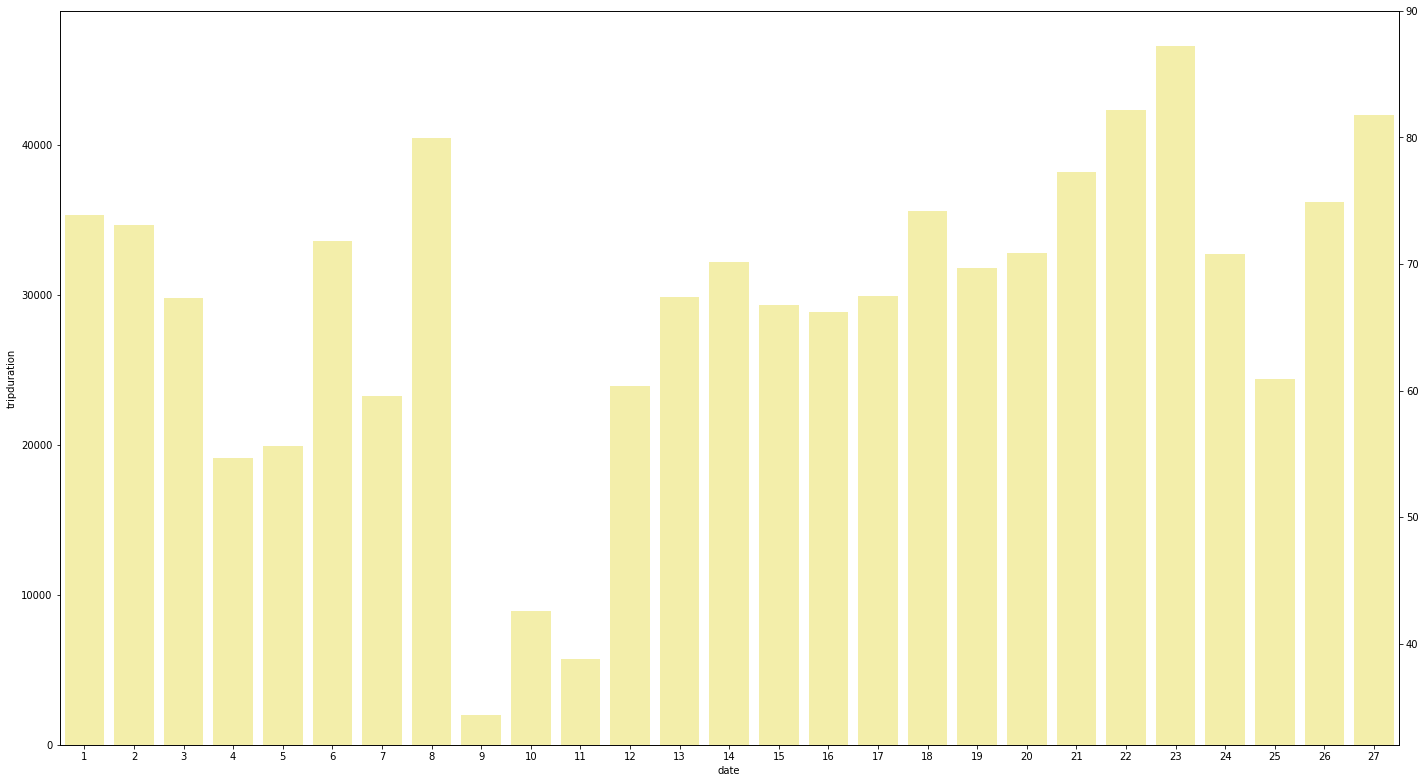

In [29]:
tmp = df[df.month==2].groupby(['date']).tripduration.size().reset_index()
tmp['date'] = tmp['date'].map(col_encode(tmp['date']))+1

fig, ax = plt.subplots(figsize=(24,13.5))
ax2 = ax.twinx()

sns.barplot(x="date", y="tripduration", data=tmp, color="#fff89e", ax=ax);

ax.set_ylim(0, None)
ax2.set_ylim(32, 90)
#plt.title('Trip numbers in each month along average temperature', fontsize=20)
plt.show()

In [30]:
display_all(df.sample(5))

,tripduration,start station id,end station id,birth year,gender,starthour,date,weekday,weekend,month,Temp_high,Temp_avg,Temp_low,Precip,Rain,Snow,Fog,rain_vol,temp_level,start_cluster,end_cluster,user_enc,est_dist,temp_diff
16062533,1063,441,297,1989,2,18.5,2017-12-21,4,0,12,39,36,32,0.00,0,0,0,0,0,13,9,1,4591,-12
9605005,433,514,523,1978,1,7.0,2017-08-21,1,0,8,87,79,71,0.00,0,0,0,0,4,1,7,1,1957,6
9921670,493,3463,442,1985,1,9.0,2017-08-26,6,1,8,78,70,62,0.00,0,0,0,0,3,9,1,1,1914,0
15375911,249,497,504,1968,1,12.5,2017-12-02,6,1,12,48,44,39,0.00,0,0,0,0,0,9,9,1,1475,-4
13923113,174,3101,3109,1990,1,23.5,2017-10-30,1,0,10,61,54,46,0.25,1,0,0,3,1,15,15,1,736,-6


In [31]:
tmp = pd.read_csv('nyc_temp_2017.csv')
tmp['2017'] = pd.to_datetime(tmp['2017'])
tmp.columns = ['date', 'Temp_high', 'Temp_avg', 
               'Temp_low', 'Precip', 'Rain', 
               'Snow', 'Fog', 'off_work',
               'snow_plus_1']
tmp.sample(10)

,date,Temp_high,Temp_avg,Temp_low,Precip,Rain,Snow,Fog,off_work,snow_plus_1
97,2017-04-08,57,49,40,0,0,0,0,0,0
213,2017-08-02,86,78,69,0.09,1,0,0,0,0
289,2017-10-17,58,50,42,0,0,0,0,0,0
280,2017-10-08,77,75,72,0.22,1,0,0,0,0
17,2017-01-18,41,40,38,0.06,1,0,0,0,0
324,2017-11-21,58,50,42,0,0,0,0,0,0
34,2017-02-04,34,28,22,0,0,0,0,0,0
0,2017-01-01,46,44,41,0,0,0,0,1,0
48,2017-02-18,63,49,35,0,0,0,0,0,0
91,2017-04-02,63,52,40,0,0,0,0,0,0


In [32]:
tmp = tmp[['date', 'off_work', 'snow_plus_1']]

In [33]:
tmp.sample(3)

,date,off_work,snow_plus_1
39,2017-02-09,0,0
190,2017-07-10,0,0
37,2017-02-07,0,0


In [34]:
%%time
df = pd.merge(df, tmp, 'left', on='date')

CPU times: user 6.85 s, sys: 5.94 s, total: 12.8 s
Wall time: 12.9 s


In [36]:
df.sample(5)

,tripduration,start station id,end station id,birth year,gender,starthour,date,weekday,weekend,month,...,Fog,rain_vol,temp_level,start_cluster,end_cluster,user_enc,est_dist,temp_diff,off_work,snow_plus_1
14610159,765,519,285,1956,2,19.0,2017-11-13,1,0,11,...,0,2,0,13,9,1,3376,1,0,0
9757050,405,3428,3255,1981,1,16.0,2017-08-23,3,0,8,...,0,1,3,1,1,1,1848,-8,0,0
11525650,485,3431,359,1995,2,8.0,2017-09-22,5,0,9,...,0,0,3,13,13,1,1276,2,0,0
9525799,996,151,3435,-1,0,16.0,2017-08-19,6,1,8,...,0,0,4,5,4,0,508,4,0,0
8544613,136,528,476,1977,1,14.5,2017-08-02,3,0,8,...,0,2,4,9,9,1,404,-6,0,0


In [37]:
df.to_feather('df_train')